In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
import sklearn
print(sklearn.__version__)


1.3.1


In [4]:
# Cargar los datos de viajes en taxi
file_path_taxi = '../Datasets/yellow_tripdata_2023-09s.csv'
taxi_data = pd.read_csv(file_path_taxi, low_memory=False)

# Cargar los datos de mapeo de boroughs
file_path_boroughs = '../Datasets/taxi+_zone_lookup.csv'
borough_data = pd.read_csv(file_path_boroughs)

In [5]:

# Preprocesamiento y mapeo de PULocationID y DOLocationID a los boroughs
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data_with_boroughs = taxi_data.merge(borough_data[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
taxi_data_with_boroughs.rename(columns={'Borough': 'PUBorough'}, inplace=True)

taxi_data_with_boroughs = taxi_data_with_boroughs.merge(borough_data[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
taxi_data_with_boroughs.rename(columns={'Borough': 'DOBorough'}, inplace=True)
taxi_data_with_boroughs.drop(['LocationID_x', 'LocationID_y'], axis=1, inplace=True)


In [6]:

# Agrupar y analizar los datos por borough, día de la semana y hora del día
taxi_data_with_boroughs['pickup_hour'] = taxi_data_with_boroughs['tpep_pickup_datetime'].dt.hour
taxi_data_with_boroughs['pickup_day_of_week'] = taxi_data_with_boroughs['tpep_pickup_datetime'].dt.dayofweek
grouped_data = taxi_data_with_boroughs.groupby(['PUBorough', 'pickup_day_of_week', 'pickup_hour']).size().reset_index(name='trip_count')


In [7]:
# Preparar los datos para el modelado
one_hot_boroughs = pd.get_dummies(grouped_data['PUBorough'], prefix='Borough')
model_data = pd.concat([grouped_data, one_hot_boroughs], axis=1)
model_data.drop(['PUBorough'], axis=1, inplace=True)

X = model_data.drop('trip_count', axis=1)
y = model_data['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
# Definir los modelos a probar
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Función para entrenar y evaluar modelos
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    model_results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        model_results[name] = {
            'model': model,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'Predictions': y_pred
        }
    return model_results

# Entrenar y evaluar los modelos
results = train_and_evaluate(models, X_train, X_test, y_train, y_test)


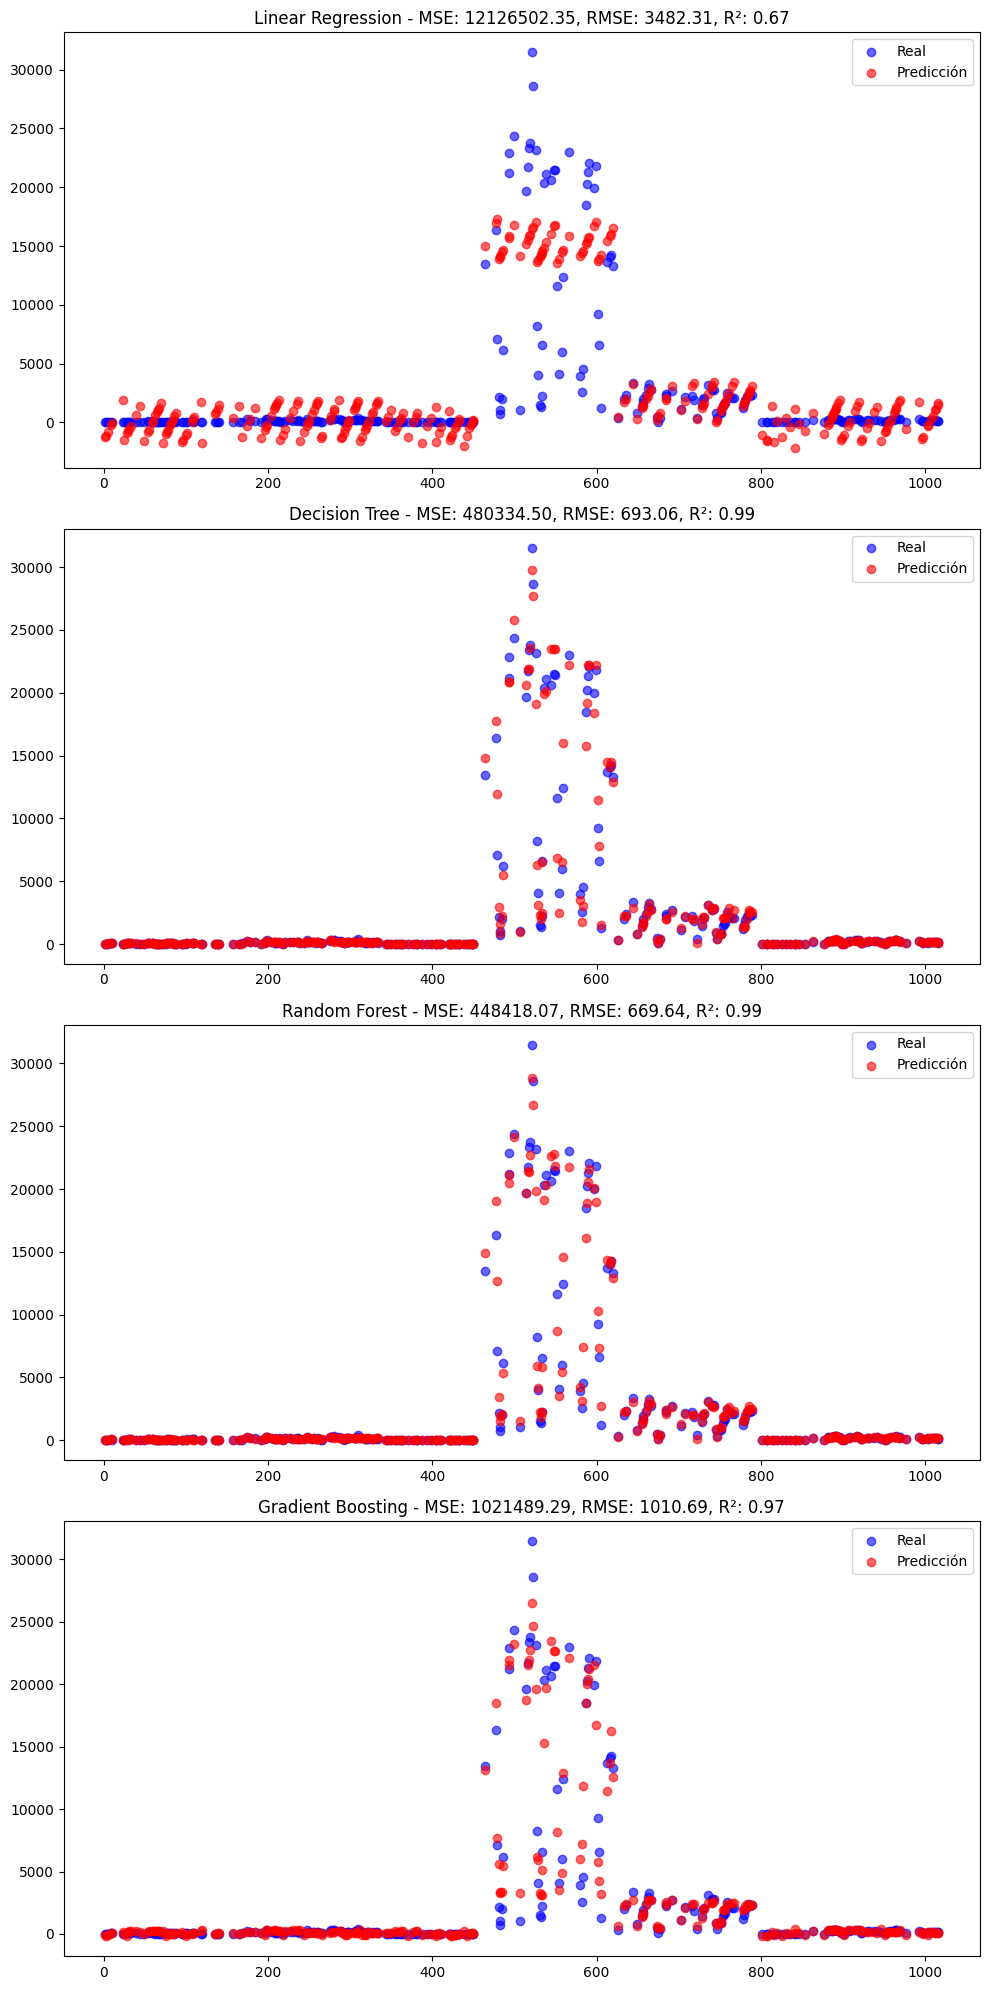

In [9]:
# Función para visualizar las diferencias
def plot_predictions(results, X_test, y_test):
    fig, axes = plt.subplots(len(results), 1, figsize=(10, 5 * len(results)))
    if len(results) == 1:  # Ajuste para cuando solo hay un modelo
        axes = [axes]
    for ax, (name, result) in zip(axes, results.items()):
        ax.scatter(X_test.index, y_test, color='blue', label='Real', alpha=0.6)
        ax.scatter(X_test.index, result['Predictions'], color='red', label='Predicción', alpha=0.6)
        ax.set_title(f'{name} - MSE: {result["MSE"]:.2f}, RMSE: {result["RMSE"]:.2f}, R²: {result["R²"]:.2f}')
        ax.legend()
    plt.tight_layout()

# Visualizar las predicciones
plot_predictions(results, X_test, y_test)


In [10]:
# Crear una tabla con los resultados de rendimiento
performance_data = {name: {'MSE': results[name]['MSE'], 
                           'RMSE': results[name]['RMSE'], 
                           'R²': results[name]['R²']} for name in results}
performance_table = pd.DataFrame(performance_data).T
performance_table


,MSE,RMSE,R²
Linear Regression,1.212650e+07,3482.312788,0.671340
Decision Tree,4.803345e+05,693.061686,0.986982
Random Forest,4.484181e+05,669.640257,0.987847
Gradient Boosting,1.021489e+06,1010.687532,0.972315


### Interpretación de los resultados:

**Linear Regression**: Presenta el peor desempeño con errores más altos (MSE y RMSE) y explica aproximadamente el 67% de la variabilidad de los datos (R²).

**Decision Tree**: Muestra una mejora significativa en el desempeño con errores mucho menores y explica cerca del 99% de la variabilidad.

**Random Forest**: Ofrece el mejor desempeño con los errores más bajos y explica ligeramente más del 99% de la variabilidad, superando marginalmente al Árbol de Decisión.

**Gradient Boosting**: Tiene un buen desempeño con errores menores que la Regresión Lineal y mayores que el Árbol de Decisión y el Bosque Aleatorio, explicando alrededor del 97% de la variabilidad.


### Recomendación
Basándonos en los resultados presentados, la recomendación sería utilizar el modelo de **Bosque Aleatorio (Random Forest)** para este conjunto de datos. Aquí están las razones principales:

**Menor Error**: El Bosque Aleatorio tiene los valores más bajos de MSE (Mean Squared Error) y RMSE (Root Mean Squared Error), lo que indica que tiende a cometer menos errores en sus predicciones en comparación con los otros modelos.

**Alta Explicabilidad**: Con un valor de R² (Coeficiente de Determinación) ligeramente superior al 99%, el Bosque Aleatorio explica casi completamente la variabilidad de la variable dependiente a través de las variables independientes.

**Balance entre Sobreajuste y Generalización**: Los modelos de Bosque Aleatorio son conocidos por su capacidad de manejar bien el sobreajuste, especialmente en comparación con modelos más simples como la Regresión Lineal o modelos más complejos como el Árbol de Decisión.